# Homework 8

In this homework we experiment with solving PDE numerically. 

We have already solved the Laplace equation with zero righ-hand side in a previous problem set. For a change, let us now consider the Laplace equation with zero boundary condition and nonzero right-hand side.

Let us solve the following problem
$$ \begin{aligned} \Delta u &= -1 \text{ in } [0,1]^2, \\
u &= 0 \text{ on } \partial [0,1]^2. \end{aligned} $$

Let us discretize the value of $u$ with an $(N+2) \times (N+2)$ grid. Here $u_{0,j}$, $u_{N+1,j}$, $u_{i,0}$ and $u_{i,N+1}$ are all equal to zero because it is the boundary values. We do not need to store these values. we can focus on computing $u_{i,j}$ for $i,j = 1,2,\dots,N$. We have $h=1/(N+1)$.

## Laplace equation

Write the finite difference scheme for $u_{i,j}$ corresponding to the Laplace equation above.

The scheme should take the form of a system of linear equations. We want to solve it using some of the methods from earlier homework. It is up to you to copy/paste the one of your choice.

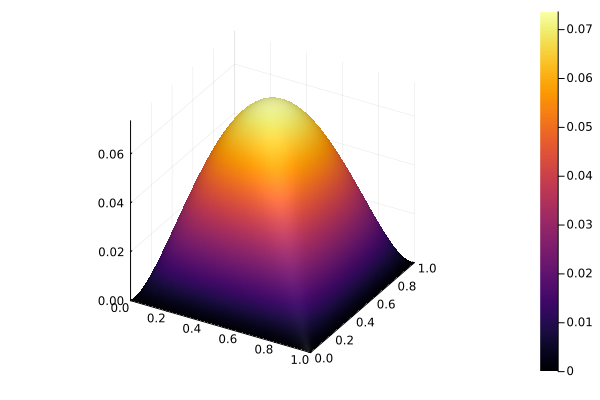

In [1]:
function T(u::Array{<:Real,2})
    n, m = size(u)
    v = similar(u) # This line creates another array with the same dimensions and type as u
    for i in 1:n
        for j in 1:m
            v[i,j] = 4*u[i,j]
            if i>1 v[i,j] -= u[i-1,j] end
            if i<n v[i,j] -= u[i+1,j] end
            if j>1 v[i,j] -= u[i,j-1] end
            if j<m v[i,j] -= u[i,j+1] end
        end
    end
    return v
end

function inner_product(u::Array{<:Real,2}, v::Array{<:Real,2})
    s = 0
    n,m = size(u)
    for i in 1:n
        for j in 1:m
            s += u[i,j] * v[i,j]
        end
    end
    return s
end

function conjugate_gradients(T::Function, u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    old_s = b
    for i in 1:iterations
        r = T(u) - b
        s = r
        if i>1
            s -= ( inner_product(T(s),old_s)/inner_product(T(old_s),old_s) ) * old_s
        end
        a = inner_product(r,s) / inner_product(T(s),s)
        u = u - a*s
        old_s = s
    end
    return u
end

using Plots
let N=100
    h = 1/(N+1)
    b = h^2*ones(N,N)
    u = zeros(N,N)
    u = conjugate_gradients(T,u,b,N^2)
    u_with_boundary = [ (((1<i<N+2)&&(1<j<N+2)) ? u[i-1,j-1] : 0) for i in 1:N+2, j in 1:N+2]
    surface(0:h:1,0:h:1,u_with_boundary)
end


## 1D Heat equation

Let us try the heat equation now.
$$ u_t - \Delta_x u = 0. $$

We will compute it in 1D and 2D. Let us start with 1D.
\begin{align}
u_t - u_{xx} &= 0 && \text{ for } t>0, x \in (0,1), \\
u(t,0) &= u(t,1) = 0, && \text{ for } t>0, \\
u(0,x) &= f(x) && \text{given.}
\end{align}

We also discretize the problem in space and time. But we do not need to save the values of $u$ for all computed times. Let us iterate over a one dimensional array `u[i]` so that at the *current* time $t$ we have $u(t,ih) \approx \mathrm{u}[i]$.

Let us use a variable $k$ to denote the time step. The following function is supposed to compute one time step.

In [2]:
function heat_time_step(u::Array{<:Real,1}, k::Real)
    N = length(u)
    h = 1/(N+1)  # We implicitly take u[0] = u[N+1] = 0 corresponding to the boundary value.
    v = similar(u)
    v[1] = u[1] + k*(u[2]-2*u[1])/h^2
    v[N] = u[N] + k*(u[N-1]-2*u[N])/h^2
    for i in 2:N-1
        v[i] = u[i] + k*(u[i+1]+u[i-1]-2*u[i])/h^2
    end
    return v
end

heat_time_step (generic function with 1 method)

### Movie time!

The time of the movie corresponds to the value of $t$. If we use a smaller step size `k`, the movie will run at the same speed. The computation to produce the movie will take longer.

In [3]:
function do_nice_movie(k::Real, N::Integer, f::Function)
    h = 1/(N+1)
    u = [ f(h*i) for i in 1:N ]

    t = 0
    return @animate for time in 1:120
        u_with_boundary = [0,u...,0]
        plot(0:h:1,u_with_boundary, ylims=(-1,1), label="time "*string(time/10000))
        while t < time / 10000
            u = heat_time_step(u,k)
            t += k
        end
    end
end

do_nice_movie (generic function with 1 method)

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif")
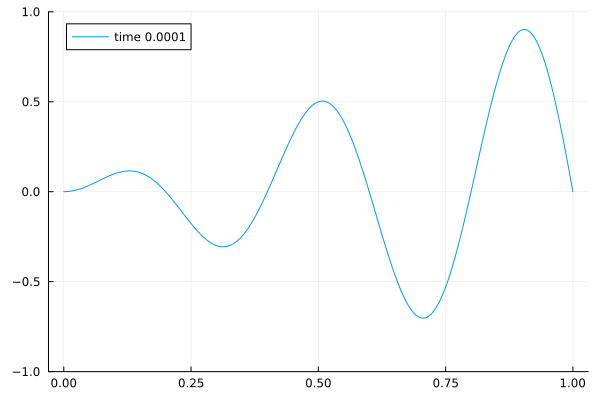

In [4]:
f(x) = x * sin(5*pi*x) # Haven't I seen this initial value somewhere?
N = 200
k = 0.000001
gif(do_nice_movie(k,N,f))

The solution should be practically flat by the time = $0.015$. We used a tiny value for the time step $k = 0.000001$. Can we use a larger value for `k`? What's the largest value of $k$ we can put in there before the scheme becomes unstable?

**Answer**. The scheme will be unstable if $k > h^2/2$. Let us try.

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif")
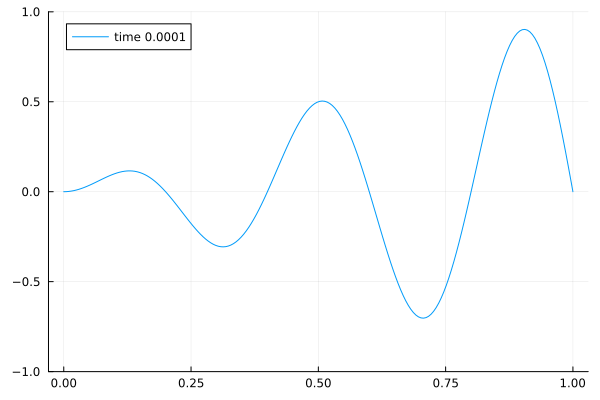

In [5]:
f(x) = x * sin(5*pi*x)
N = 200
k = 1.01 * (1/(N+1)^2) / 2
gif(do_nice_movie(k,N,f))

## 2D Heat equation

Let us continue with 2D.
\begin{align}
u_t - u_{xx} - u_{yy} &= 0 && \text{ for } t>0, x \in (0,1), y \in (0,1) \\
u(t,x,y) &= 0, && \text{ if $x$ or $y$ equals $0$ or $1$} , \\
u(0,x,y) &= f(x,y) && \text{given.}
\end{align}

Now we iterate over a two dimensional array `u[i,j]` so that at the *current* time $t$ we have $u(t,ih,jh) \approx \mathrm{u}[i,j]$.

As before, the variable $k$ denotes the time step. The following function is supposed to compute one time step.

In [6]:
function heat_time_step(u::Array{<:Real,2}, k::Real)
    N,M = size(u)
    h = 1/(N+1)  # We implicitly take u[0] = u[N+1] = 0 corresponding to the boundary value.
    v = similar(u)
    for i in 1:N
        for j in 1:M
            v[i,j] = u[i,j] - 4*k*u[i,j]/h^2
            if (i>1) v[i,j] += k*u[i-1,j]/h^2 end
            if (i<N) v[i,j] += k*u[i+1,j]/h^2 end
            if (j>1) v[i,j] += k*u[i,j-1]/h^2 end
            if (j<N) v[i,j] += k*u[i,j+1]/h^2 end
        end
    end
    return v
end

heat_time_step (generic function with 2 methods)

In [7]:
function do_nice_3d_movie(k::Real, N::Integer, f::Function)
    h = 1/(N+1)
    u = [ f(h*i,h*j) for i in 1:N, j in 1:N ]

    t = 0
    return @animate for time in 1:100
        u_with_boundary = [ (((1<i<N+2)&&(1<j<N+2)) ? u[i-1,j-1] : 0) for i in 1:N+2, j in 1:N+2]
        surface(0:h:1,0:h:1,u_with_boundary, zlims=(-1,1), label="time "*string(time/10000))
        while t < time / 10000
            u = heat_time_step(u,k)
            t += k
        end
    end
end

do_nice_3d_movie (generic function with 1 method)

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif")
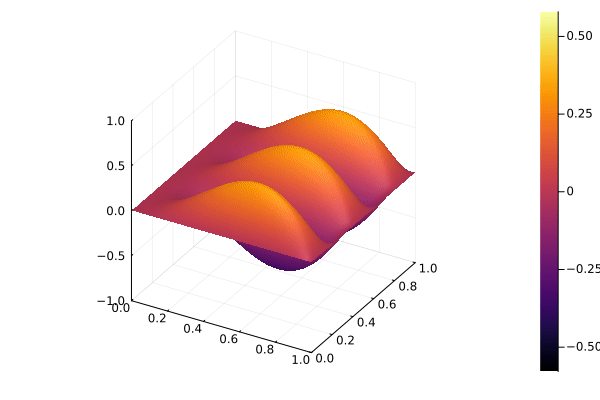

In [8]:
f(x,y) = y * sin(5*pi*x) * sin(pi*y)
N = 100
k = 0.00001
gif(do_nice_3d_movie(k,N,f))

## Wave equation.

Let us try to do the wave equation now. The equation is the following.
\begin{align}
u_{tt} &= \Delta_x u, && \text{ for } t>0, x \in (0,1), \\
u(t,0) &= u(t,1) = 0, && \text{ for } t>0, x \in \{0,1\}, \\
u(0,x) &= f(x) && \text{ given, }\\
u_t(0,x) &= g(x) && \text{ given. }
\end{align}

This equation involves a second derivative with respect to time. Consquently, it takes two initial values: for $u(0,x)$ and $u_t(0,x)$. We can think about it as the following system, which we get by calling $v := u_t$.

\begin{align}
u_t &= v, && \text{ for } t>0, x \in (0,1), \\
v_t &= \Delta_x u, && \text{ for } t>0, x \in (0,1), \\
u(t,x) &= v(t,x) = 0, && \text{ for } t>0, x \in \{0,1\}, \\
u(0,x) &= f(x) && \text{ given, }\\
v(0,x) &= g(x) && \text{ given. }
\end{align}

We use two arrays `u[i]` and `v[i]` which should approximately correspond to the values of $u(t,hi)$ and $v(t,hi) = u_t(t,hi)$, as they evolve in time.

The plan: write a finite difference scheme for the wave equation and cross our fingers.

In [17]:
function wave_time_step(u::Array{<:Real,1}, v::Array{<:Real,1}, k::Real)
    N = length(u)
    @assert N == length(v)
    h = 1/N
    un = similar(u)
    vn = similar(u)
    for i in 1:N
        un[i] = u[i] + k*v[i]
        vn[i] = v[i] - k*2*u[i]/h^2
        if i>1 vn[i] += k*u[i-1]/h^2 end
        if i<N vn[i] += k*u[i+1]/h^2 end
    end
    return un, vn
end

wave_time_step (generic function with 2 methods)

In [14]:
function do_wave_movie(k::Real, N::Integer, f::Function, g::Function)
    h = 1/(N-1)
    u = [ f(h*i) for i in 1:N ]
    v = [ g(h*i) for i in 1:N ]

    t = 0
    return @animate for time in 1:300
        plot(0:h:1, u, ylims=(-1,2), label="time "*string(time/10000))
        while t < time / 100
            u,v = wave_time_step(u,v,k)
            t += k
        end
    end
end

do_wave_movie (generic function with 1 method)

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/tmp.gif")
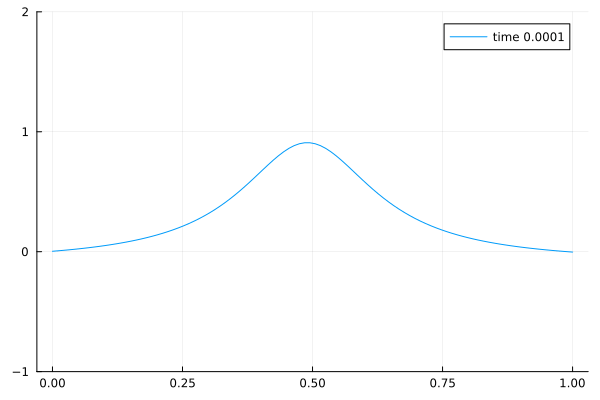

In [18]:
f(x) = 1 / (1+40*(x-0.5)^2) - 1/11
g(x) = 0
gif(do_wave_movie(0.0001,100,f,g))

The solution looks decent for a while, and then it starts doing funny things. It would work much better to use Fourier series to compute a solution to the wave equation, like [on my website](https://math.uchicago.edu/~luis/pde/wave.html).